#**Blending - XgBoost (Regression)**

**Import Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing  # For regression dataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

**Code**

In [2]:
# Load the California housing dataset
data = fetch_california_housing()
X, y = data.data, data.target

In [3]:
# Split the dataset into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Further split the training set into train and validation sets (for blending)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [5]:
# Define base regressors
base_regressors = [
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('adaboost', AdaBoostRegressor(n_estimators=50, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42)),
]

In [6]:
# Step 1: Train base regressors on the training set
val_predictions = np.zeros((X_val.shape[0], len(base_regressors)))  # Placeholder for validation predictions
test_predictions = np.zeros((X_test.shape[0], len(base_regressors)))  # Placeholder for test set predictions
fitted_regressors = []  # To store fitted regressor instances

for i, (name, reg) in enumerate(base_regressors):
    # Clone the regressor to avoid overwriting during blending
    reg_instance = clone(reg)

    # Train on the full training set
    reg_instance.fit(X_train, y_train)
    fitted_regressors.append(reg_instance)  # Store the fitted instance

    # Store predictions on the validation set (for blending)
    val_predictions[:, i] = reg_instance.predict(X_val)

    # Store predictions on the test set
    test_predictions[:, i] = reg_instance.predict(X_test)

In [7]:
# Step 2: Blend predictions using Linear Regression
blender = LinearRegression()
blender.fit(val_predictions, y_val)

LinearRegression()

In [8]:
# Step 3: Make final predictions on the test set using the blender
final_predictions = blender.predict(test_predictions)

In [9]:
# Calculate and display the mean squared error of the blended model
mse = mean_squared_error(y_test, final_predictions)
print(f'Blended Model MSE: {mse:.2f}')

Blended Model MSE: 0.23


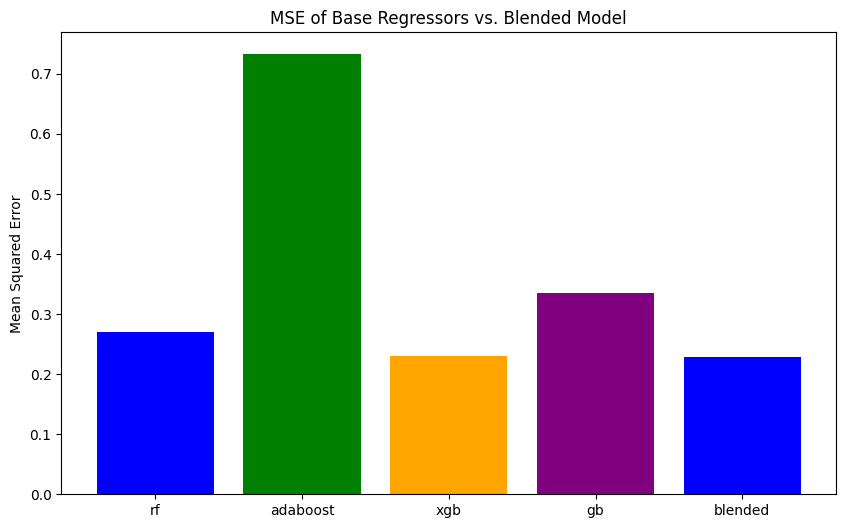

In [10]:
# Visualize individual regressor performance and blended model performance
individual_mses = []

for reg_instance, (name, _) in zip(fitted_regressors, base_regressors):
    reg_pred = reg_instance.predict(X_test)
    mse_individual = mean_squared_error(y_test, reg_pred)
    individual_mses.append((name, mse_individual))

# Plot individual regressor MSE vs. blended model MSE
names, mses = zip(*individual_mses)
plt.figure(figsize=(10, 6))
plt.bar(names + ('blended',), mses + (mse,), color=['blue', 'green', 'orange', 'purple'])
plt.ylabel('Mean Squared Error')
plt.title('MSE of Base Regressors vs. Blended Model')
plt.show()

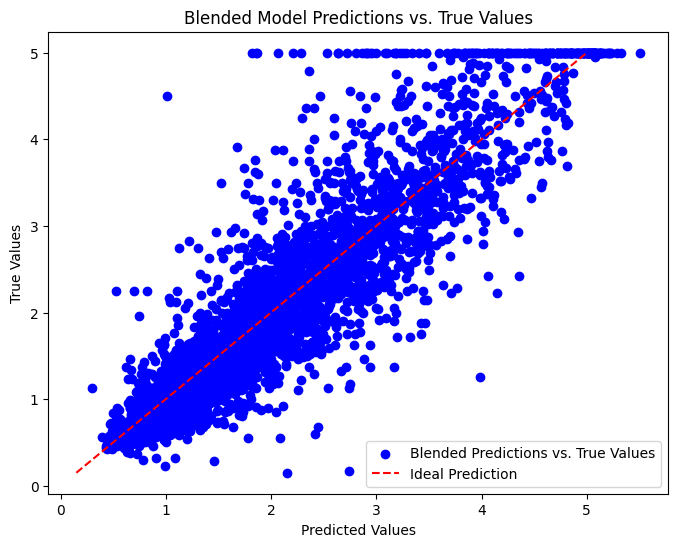

In [11]:
# Scatter plot for blended predictions vs. true values
plt.figure(figsize=(8, 6))
plt.scatter(final_predictions, y_test, color='blue', label='Blended Predictions vs. True Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Ideal Prediction')
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.legend()
plt.title('Blended Model Predictions vs. True Values')
plt.show()